# QL Environement
We will have player blob, food and enemy, initialise randomly on a map.
The goal will be to eat all food without to touch the enemies.

## Imports

In [21]:
# Import standard libraries
import time
import base64
from enum import IntEnum

# Import third-party libraries
import cv2
import numpy as np
import imageio
import pickle
from PIL import Image
from matplotlib import style
import IPython
from IPython.display import display, clear_output
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt

# Set matplotlib to inline mode
%matplotlib inline

## Matplotlib Style

In [2]:
style.use("ggplot")

## Constants

In [3]:
# Env params
SIZE = 10
HM_EPISODES = 250000
SHOW_EVERY = 3000

# rewards
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25

# QTable
start_q_table = None # or filename

# learning params
epsilon = 0.9
EPS_DECAY = 0.9998
LEARNING_RATE = 0.1
DISCOUNT = 0.95

# Game elements
PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

TILE_SIZE = 48
SPRITE_PATH = 'sprites/sprites.png'

In [4]:
class Direction(IntEnum):
    TOP = 0
    RIGHT = 1
    BOTTOM = 2
    LEFT = 3

## Blob

In [5]:
class Blob:
     """
     A class that represents a blob object in a grid-based game
     
     Attributes:
        x (int): The x-coordinate of the blob in the grid.
        y (int): The y-coordinate of the blob in the grid.
        choice (int): The direction of the blob's movement (0: top, 1: right, 2: bottom, 3: left).
    """
    def __init__(self):
        # generate random coordinates within the size limit
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
        self.choice = 2
        
    def __str__(self) -> str:
        # return the coordinate as a string
        return f"{self.x}, {self.y}"
    
    def __sub__(self, other) -> tuple:
        # subtract the coordinates of the current blob with another one and return the result as a tuple
        return (self.x - other.x, self.y - other.y)
    
    def action_movement(self, choice: Direction) -> tuple:
        """
        Return the change in x and y coordinates based on the given direction.

        Args:
            choice (Direction): An enum value that represents one of the four directions.

        Returns:
            tuple: A pair of integers that indicate the change in x and y coordinates.
        """
        if choice == Direction.TOP:
            # move up by decreasing y coordinate
            return (0, -1)
        elif choice == Direction.RIGHT:
            # move right by increasing x coordinate
            return (1, 0)
        elif choice == Direction.BOTTOM:
            # move down by increasing y coordinate
            return (0, 1)
        elif choice == Direction.LEFT:
            # move left by decreasing x coordinate
            return (-1, 0)
    
    def action(self, choice: Direction) -> None:
        """
        Update the blob's position based on the given direction.

        Args:
            choice (Direction): An enum value that represents one of the four directions.
        """
        x, y = self.action_movement(choice)
        self.move(x, y)
        self.choice = choice
    
    def move(self, x: int = None, y: int = None):
        """
        Update the blob's position based on the given x and y values.
        If x and y are None, choose a random direction and move accordingly.

        Args:
            x (int, optional): The change in x coordinate. Defaults to None.
            y (int, optional): The change in y coordinate. Defaults to None.
        """
        if x is None or y is None:
            choice = np.random.randint(0, 4)
            x, y = self.action_movement(choice)
            self.x += x
            self.y += y
            self.choice = choice
            
        else:
            self.x += x
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

## Loading QTalbe

In [6]:
# Observation space: (x1, y1), (x2, y2) => delta between player and food and between player and enemy  
if start_q_table is None:
    # if there is no start_q_table, create a new empty q_table
    q_table = {}
    
    # iterate over all possible combinations of coordinates for both players
    for x1 in range(-SIZE + 1, SIZE):
        for y1 in range(-SIZE + 1, SIZE):
            for x2 in range(-SIZE + 1, SIZE):
                for y2 in range(-SIZE + 1, SIZE):
                    # initialize each state-action pair with a random value between -5 and 0
                    q_table[((x1, y1), (x2, y2))] = [np.random.uniform(-5, 0) for i in range(4)]
                    
else:
    # if there is a start_q_table, load it from the file
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

In [7]:
class Env:
    """
    A class that represents an environment for a game with three blobs: player, food and enemy.
    """
    def __init__(self, moves = False):
        """
        Environment class to simulate Blob game.

        Args:
        - moves (bool): a flag to control if the food and the enemy blobs can move or not.

        Attributes:
        - __player (Blob): a player blob object.
        - __food (Blob): a food blob object.
        - __enemy (Blob): an enemy blob object.
        - __observation (tuple): a tuple of two vectors of distances between the player and the food and the enemy blobs.
        - __timestep (int): the number of steps that have been executed.
        - __moves (bool): a flag to control if the food and the enemy blobs can move or not.
        """
        self.__player = Blob()
        self.__food = Blob()
        self.__enemy = Blob()
        self.__observation = self.__get_observation()
        self.__timestep = 0
        self.__moves = moves
    
    def reset(self) -> tuple:
        """
        Resets the environment to its initial state and returns the observation.

        Returns:
            tuple: The observation of the environment after resetting.
        """
        self.__player = Blob()
        self.__food = Blob()
        self.__enemy = Blob()
        self.__observation = self.__get_observation()
        self.__timestep = 0
        return self.__observation
    
    def get_timestep(self) -> int:
        """
        Returns the current timestep of the environment.

        Returns:
            int: The current timestep.
        """
        return self.__timestep
        
    def __get_observation(self) -> tuple:
        """
        Return a tuple of two vectors of distances between the player and the food and the enemy blobs.

        Returns:
        - tuple: a tuple of two vectors of distances between the player and the food and the enemy blobs.
        """
        return (self.__player-self.__food, self.__player-self.__enemy)
    
    def step(self, action: Direction) -> tuple:
        """
        Execute a step in the environment.

        Args:
        - action (Direction): an action to be taken by the player blob.

        Returns:
        - tuple: a tuple with the new observation, the reward obtained, a flag indicating if the game is terminated,
        and a flag indicating if the maximum number of steps has been reached.
        """
        self.__timestep += 1
        # player action
        self.__player.action(action)
        # Other blobs Movements
        if self.__moves:
            self.__enemy.move()
            self.__food.move()
        
        # Calculate the reward
        if self.__player.x == self.__enemy.x and self.__player.y == self.__enemy.y:
            reward = -ENEMY_PENALTY
        elif self.__player.x == self.__food.x and self.__player.y == self.__food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
            
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            terminated = True
        else:
            terminated = False
            
        if self.__timestep >= 200:
            truncated = True
        else:
            truncated = False
            
        self.__observation = self.__get_observation()
        return self.__observation, reward, terminated, truncated
    
    def __get_sprite_img(self, item: int = 0, version:int = 0, w:int = 48, h:int = 48) -> tuple:
        """
        Return a tuple of four integers representing the boundaries of a region of the sprite image.

        Args:
        - item (int): the row of the sprite sheet.
        - version (int): the column of the sprite sheet.
        - w (int): the width of the region.
        - h (int): the height of the region.

        Returns:
        - tuple: a tuple of four integers representing the boundaries of a region of the sprite image.
        """
        x = w*version
        y = h*item
        return (x, y, x+w, y+h)
    
    def __load_sprite(self, sprite_image, item: int = 0, version:int = 0, w:int = 48, h:int = 48) -> np.ndarray:
        img = sprite_image.crop(self.__get_sprite_img(item, version))
        return np.asarray(img).astype(np.float32) / 255.0
    
    def __generate_mask(self, sprite_array: np.ndarray) -> np.ndarray:
        # create a transparency mask
        mask = sprite_array[..., 3]
        # add a new axis to the mask
        mask = mask[..., np.newaxis]
        # duplicate the mask along the new axis
        mask = np.repeat(mask, 4, axis=-1)
        return mask
    
    def __apply_mask(self, image: np.ndarray, mask: np.ndarray) -> np.ndarray:
        composite_array = np.zeros_like(image)
        composite_array[..., 0] = image[..., 0]  # copy red channel from image
        composite_array[..., 1] = image[..., 1]  # copy green channel from image
        composite_array[..., 2] = image[..., 2]  # copy blue channel from image
        composite_array[..., 3] = image[..., 3]  # copy blue channel from image
        composite_array[:mask.shape[0], :mask.shape[1]] -= mask
        return composite_array
    
    def __blend_sprite(self, background: np.ndarray, layer: np.ndarray) -> np.ndarray:
        # create a transparency mask
        mask = self.__generate_mask(layer)

        # apply transparency mask to background
        composite_array = self.__apply_mask(background, mask)

        # blend to image
        result = self.__blend_images(composite_array, layer)
        return result
    
    def __blend_images(self, image1: np.ndarray, image2: np.ndarray) -> np.ndarray:
        # Extract the alpha channel from the two images and average them
        alpha1 = image1[..., 3]
        alpha2 = image2[..., 3]
        alpha = (alpha1 + alpha2)

        # Blend the two images using alpha blending
        result = np.zeros_like(image1)
        result[..., 0:3] = (image1[..., 0:3] * alpha1[..., np.newaxis] + 
                            image2[..., 0:3] * alpha2[..., np.newaxis]) / alpha[..., np.newaxis]
        result[..., 3] = alpha
        return result
    
    def render_map(self):
        env_map = np.zeros((SIZE, SIZE), dtype=np.uint8)
        env_map[self.__food.y][self.__food.x] = FOOD_N
        env_map[self.__player.y][self.__player.x] = PLAYER_N
        env_map[self.__enemy.y][self.__enemy.x] = ENEMY_N
        return env_map
    
    def render(self):
        # Crop a region of the sprite image
        x, y, w, h = 0, 0, TILE_SIZE, TILE_SIZE

        sprite_image = Image.open(SPRITE_PATH)

        # Load the grass tile
        grass_array = self.__load_sprite(sprite_image, 0, 0) # empty (grass)
        player_array = self.__blend_sprite(grass_array, self.__load_sprite(sprite_image, 1, self.__player.choice)) # player (bear)
        food_array = self.__blend_sprite(grass_array, self.__load_sprite(sprite_image, 2, self.__food.choice)) # food (sheep)
        enemy_array = self.__blend_sprite(grass_array, self.__load_sprite(sprite_image, 3, self.__enemy.choice)) # enemy (hunter)

        # create a 2D numpy array of image indices
        index_array = self.render_map()
        
        # stack the images into a single NumPy array
        image_array = np.stack([grass_array, player_array, food_array, enemy_array])

        # create an empty array to hold the composite image
        map_array = np.zeros((w*SIZE, h*SIZE, 4), dtype=np.uint8)

        # fill the composite array with the images based on the index array
        for i in range(index_array.shape[0]):
            for j in range(index_array.shape[1]):
                image_index = index_array[i, j]
                image = (image_array[image_index] * 255).astype(np.uint8)
                map_array[i*h:(i+1)*h, j*w:(j+1)*w, :] = np.asarray(image)

        return map_array
    
    def __update_plot(self, frame_number, observation, options):
        num_iteration, win, lose = options
        action = np.argmax(q_table[observation])
        observation, reward, terminated, truncated = self.step(action)
        done = terminated or truncated
        state = self.render()
        
        win += 1 if reward == FOOD_REWARD else 0
        lose += 1 if reward == -ENEMY_PENALTY or truncated else 0

        # converting state to plot in order to stylize it
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(1,1,1)
        ax.imshow(state)
        ax.axis('off')
        ax.set_title(f"ts={self.get_timestep()}, action={action}, win={win}, lose={lose}")
        canvas.draw()

        # reconverting plot to state
        size = fig.get_size_inches() * fig.dpi
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

        if done:
            observation = self.reset()
            num_iteration -= 1
            time.sleep(0.5)
            
        return image, observation, (num_iteration, win, lose)
    
    def save(self):
        observation = self.reset()
        win = 0
        lose = 0
        num_iteration = 5
        images = []
        while num_iteration > 0:
            print(f"{5 - (num_iteration+1)}/{5}", end="\r")
            state, observation, (num_iteration, win, lose) = self.__update_plot(i, observation, (num_iteration, win, lose))
            images.append(Image.fromarray(state))
        print("\nSaving..............", end="\r")     
        images[0].save('img/bear_sheep_hunter.gif', format='GIF', save_all=True, append_images=images[1:], duration=100, loop=0)
        print("Saved                   ")

In [8]:
env = Env()

In [9]:
episode_rewards = []

In [10]:
for episode in range(HM_EPISODES):
    observation = env.reset()
    
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode}, epsilon: {epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:]) if len(episode_rewards) > 0 else 'nan'}")
        show = True
    else:
        show = False
    
    episode_reward = 0
    for i in range(200):
        if np.random.random() > epsilon:
            action = np.argmax(q_table[observation])
        else:
            action = np.random.randint(0, 4)
        # increment environment
        new_observation, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        
        max_future_q = np.max(q_table[new_observation])
        current_q = q_table[observation][action]
        
        if terminated:
            new_q = reward
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[observation][action] = new_q
        
        episode_reward += reward
        observation = new_observation
        if done:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

on # 0, epsilon: 0.9
3000 ep mean nan
on # 3000, epsilon: 0.49390083359356435
3000 ep mean -177.701
on # 6000, epsilon: 0.27104225936046566
3000 ep mean -128.111
on # 9000, epsilon: 0.14874221981913022
3000 ep mean -95.31033333333333
on # 12000, epsilon: 0.08162656262136181
3000 ep mean -72.687
on # 15000, epsilon: 0.044794919246742226
3000 ep mean -55.053333333333335
on # 18000, epsilon: 0.024582497729691496
3000 ep mean -39.528
on # 21000, epsilon: 0.01349035124500733
3000 ep mean -32.910333333333334
on # 24000, epsilon: 0.0074032174726434705
3000 ep mean -28.199666666666666
on # 27000, epsilon: 0.004062728090014504
3000 ep mean -24.997333333333334
on # 30000, epsilon: 0.0022295386559135037
3000 ep mean -21.110666666666667
on # 33000, epsilon: 0.0012235233340941692
3000 ep mean -15.716666666666667
on # 36000, epsilon: 0.0006714435495892111
3000 ep mean -13.878
on # 39000, epsilon: 0.000368473920947927
3000 ep mean -10.381666666666666
on # 42000, epsilon: 0.00020221064079296736
3000 e

In [11]:
def display_animation(env, num_iteration = 2):
    img = plt.imshow(env.render())
    observation = env.reset()
    win = 0
    lose = 0
    while num_iteration > 0:
        action = np.argmax(q_table[observation])
        observation, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        
        win += 1 if reward == FOOD_REWARD else 0
        lose += 1 if reward == -ENEMY_PENALTY or truncated else 0
        
        img.set_data(env.render())
        plt.axis('off')
        plt.title(f"ts={env.get_timestep()}, action={action}, win={win}, lose={lose}")
        plt.draw()
        display(plt.gcf())
        clear_output(wait=True)
        
        time.sleep(0.05)        
        if done:
            observation = env.reset()
            num_iteration -= 1
            time.sleep(0.5)

In [12]:
env2 = Env(moves=True)

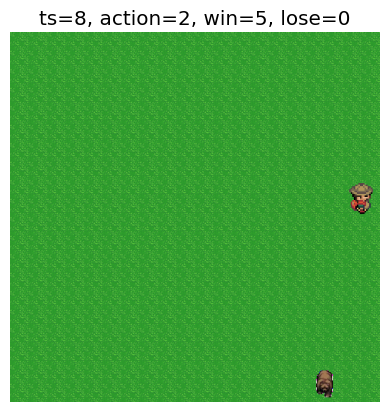

In [13]:
display_animation(env2, num_iteration=5)

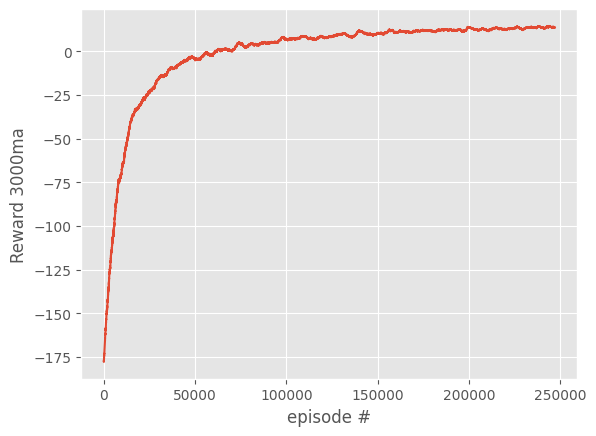

In [14]:
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

## Save q_table

In [15]:
with open(f"saves/qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

## Generate a gif

In [17]:
def embed_gif(filename):
    """Embeds an mp4 file in the notebook."""
    gif = open(filename,'rb').read()
    b64 = base64.b64encode(gif)
    tag = '''<img width="840" height="480"  src="data:img/gif;base64,{0}"/>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [16]:
env2.save()

4/5
Saved                   


In [22]:
filename = "./img/bear_sheep_hunter.gif"
embed_gif(filename)